<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Load-Datasets" data-toc-modified-id="Load-Datasets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Datasets</a></span></li></ul></div>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Datasets

In [2]:
hours_df = pd.read_csv("https://raw.githubusercontent.com/ashomah/Bike-Sharing-in-Washington/master/Bike-Sharing-Dataset/hour.csv")
hours_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [3]:
days_df = pd.read_csv("https://raw.githubusercontent.com/ashomah/Bike-Sharing-in-Washington/master/Bike-Sharing-Dataset/day.csv")
days_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [4]:
########################### HOURS DATASET ###########################
# Renaming columns names to more readable names
hours_df.rename(columns={'instant':'id',
                        'dteday':'date',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_bikes',
                        'hr':'hour',
                        'yr':'year',
                        'temp':'actual_temp',
                        'atemp':'feeling_temp'},inplace=True)
###########################
# Setting proper data types
###########################
# date time conversion
hours_df.date = pd.to_datetime(hours_df.date, format='%Y-%m-%d')
# categorical variables
for column in ['season', 'holiday', 'weekday', 'workingday', 'weather_condition','month', 'year','hour']:
    hours_df[column] = hours_df[column].astype('category')
    
########################### DAYS DATASET ###########################
# Renaming columns names to more readable names
days_df.rename(columns={'instant':'id',
                        'dteday':'date',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_bikes',
                        'yr':'year',
                        'temp':'actual_temp',
                        'atemp':'feeling_temp'},inplace=True)
###########################
# Setting proper data types
###########################
# date time conversion
days_df.date = pd.to_datetime(days_df.date, format='%Y-%m-%d')
# categorical variables
for column in ['season', 'holiday', 'weekday', 'workingday', 'weather_condition','month', 'year']:
    hours_df[column] = hours_df[column].astype('category')
    
#####################################################################
print('################################# HOURS DATASET #############################################')
print(hours_df.head())
print('################################# HOURS DATASET #############################################')
print(hours_df.describe())
print('################################# DAYS DATASET #############################################')
print(days_df.head())
print('################################# DAYS DATASET #############################################')
print(days_df.describe())



################################# HOURS DATASET #############################################
   id       date season year month hour holiday weekday workingday  \
0   1 2011-01-01      1    0     1    0       0       6          0   
1   2 2011-01-01      1    0     1    1       0       6          0   
2   3 2011-01-01      1    0     1    2       0       6          0   
3   4 2011-01-01      1    0     1    3       0       6          0   
4   5 2011-01-01      1    0     1    4       0       6          0   

  weather_condition  actual_temp  feeling_temp  humidity  windspeed  casual  \
0                 1         0.24        0.2879      0.81        0.0       3   
1                 1         0.22        0.2727      0.80        0.0       8   
2                 1         0.22        0.2727      0.80        0.0       5   
3                 1         0.24        0.2879      0.75        0.0       3   
4                 1         0.24        0.2879      0.75        0.0       0   

   registe

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


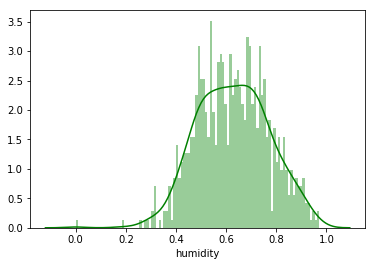

In [5]:
sns.distplot(days_df['humidity'], color='g', bins=100, hist_kws={'alpha': 0.4}) ;


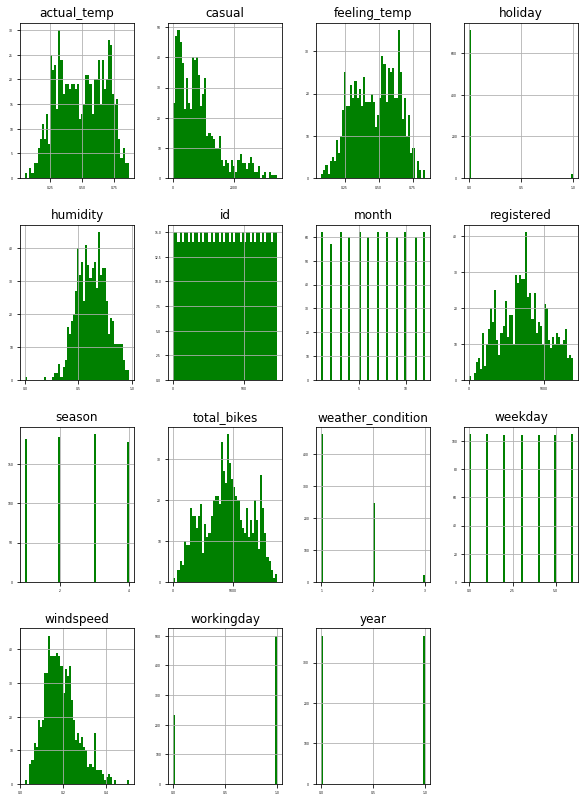

In [6]:
days_df_num = days_df.select_dtypes(include = ['float64', 'int64']);
days_df_num.hist(figsize=(10, 14), bins=50, xlabelsize=3, ylabelsize=3, color ='g');

In [7]:
days_num_corr = days_df_num.corr()['total_bikes'][:-1] # -1 because the latest row is SalePrice
golden_features_list = days_num_corr[abs(days_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Total Bikes:\n{}".format(len(golden_features_list), golden_features_list))

There is 6 strongly correlated values with Total Bikes:
registered      0.945517
casual          0.672804
feeling_temp    0.631066
id              0.628830
actual_temp     0.627494
year            0.566710
Name: total_bikes, dtype: float64


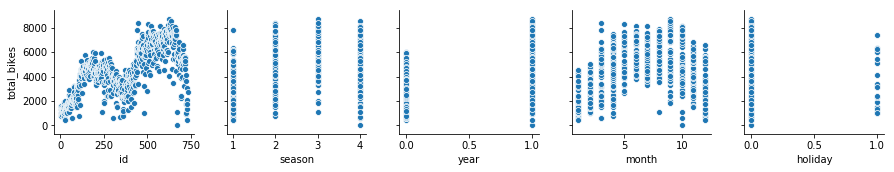

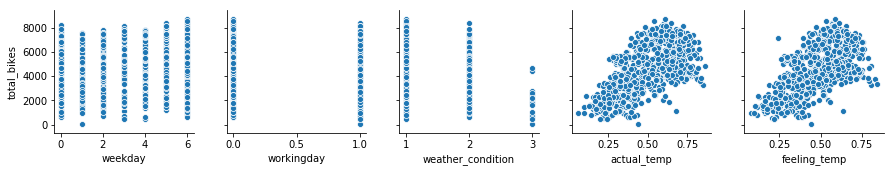

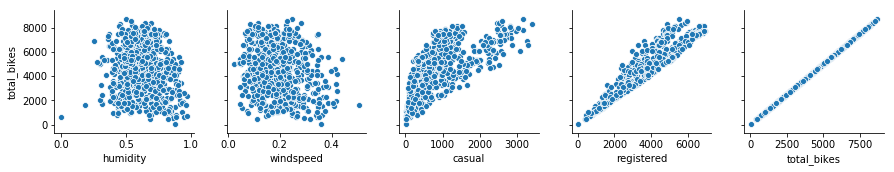

In [8]:
for i in range(0, len(days_df_num.columns), 5):
    sns.pairplot(data=days_df_num,
                x_vars=days_df_num.columns[i:i+5],
                y_vars=['total_bikes'])

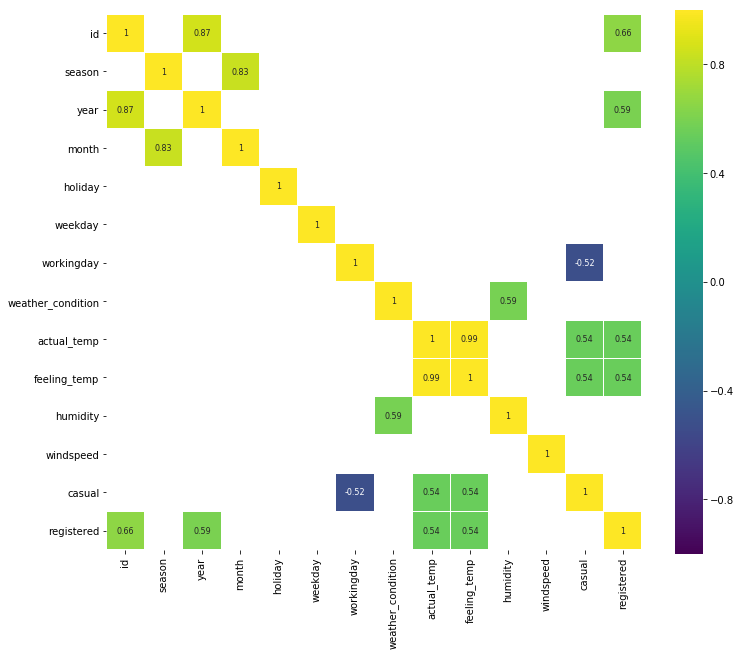

In [9]:
corr = days_df_num.drop('total_bikes', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

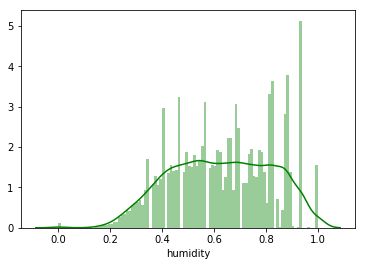

In [10]:
sns.distplot(hours_df['humidity'], color='g', bins=100, hist_kws={'alpha': 0.4}) ;

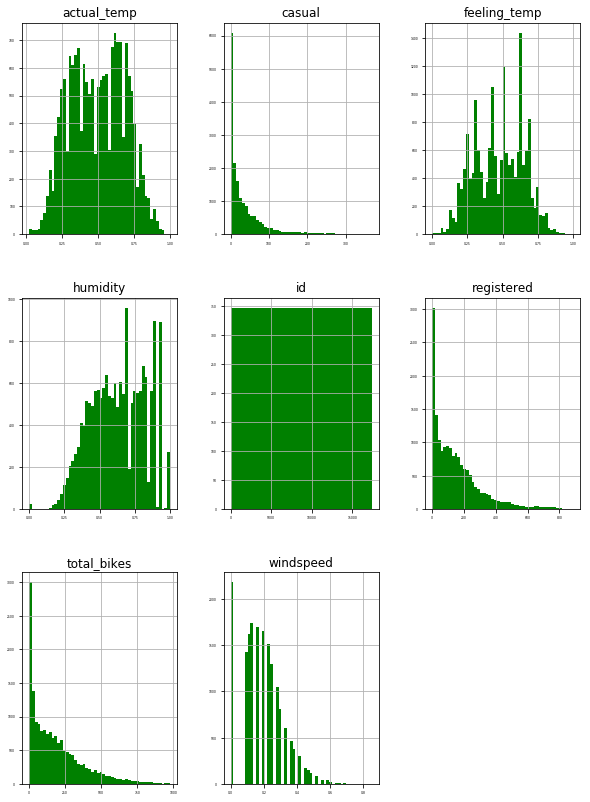

In [11]:
hours_df_num = hours_df.select_dtypes(include = ['float64', 'int64']);
hours_df_num.hist(figsize=(10, 14), bins=50, xlabelsize=3, ylabelsize=3, color='g');

In [12]:
hours_num_corr = hours_df_num.corr()['total_bikes'][:-1] # -1 because the latest row is SalePrice
golden_features_list_1 = hours_num_corr[abs(hours_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Total Bikes:\n{}".format(len(golden_features_list_1), golden_features_list_1))

There is 2 strongly correlated values with Total Bikes:
registered    0.972151
casual        0.694564
Name: total_bikes, dtype: float64


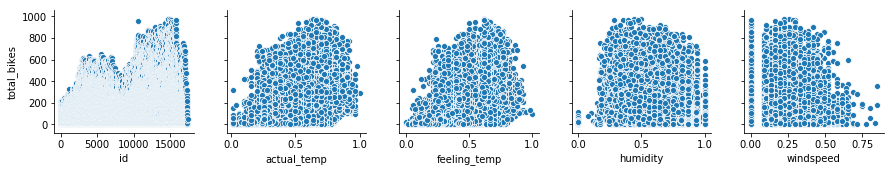

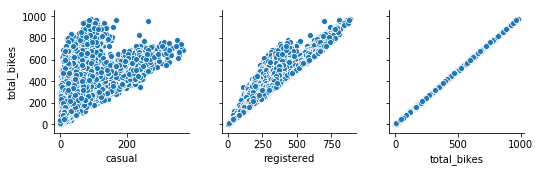

In [13]:
for i in range(0, len(hours_df_num.columns), 5):
    sns.pairplot(data=hours_df_num,
                x_vars=hours_df_num.columns[i:i+5],
                y_vars=['total_bikes'])

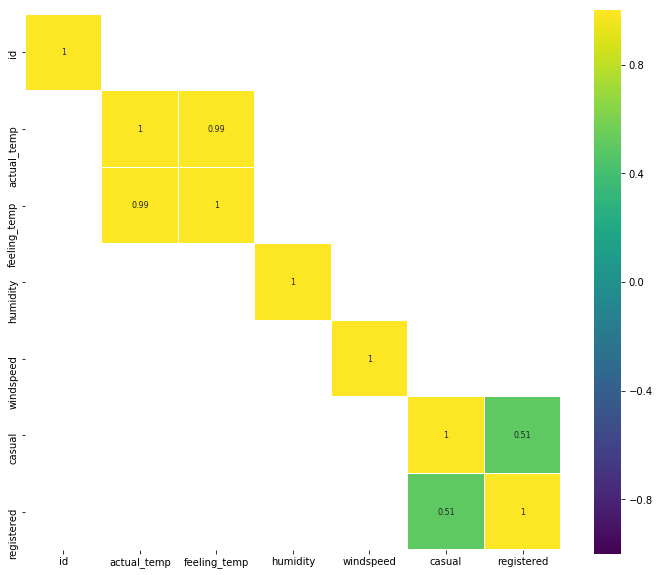

In [14]:
corr_1 = hours_df_num.drop('total_bikes', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr_1[(corr_1 >= 0.5) | (corr_1 <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [15]:
hours_df_cat = hours_df.select_dtypes(include = ['category']);
hours_df_cat.head()

,season,year,month,hour,holiday,weekday,workingday,weather_condition
0,1,0,1,0,0,6,0,1
1,1,0,1,1,0,6,0,1
2,1,0,1,2,0,6,0,1
3,1,0,1,3,0,6,0,1
4,1,0,1,4,0,6,0,1


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

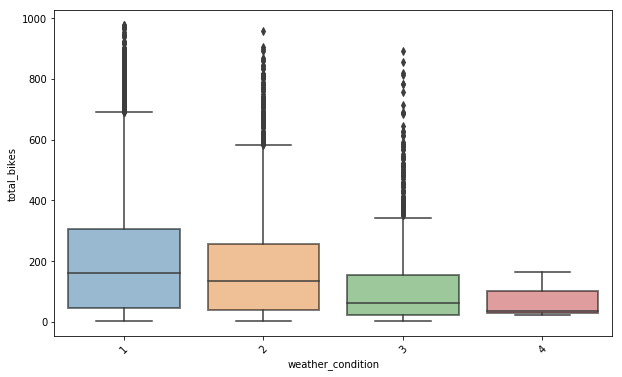

In [16]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='weather_condition', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

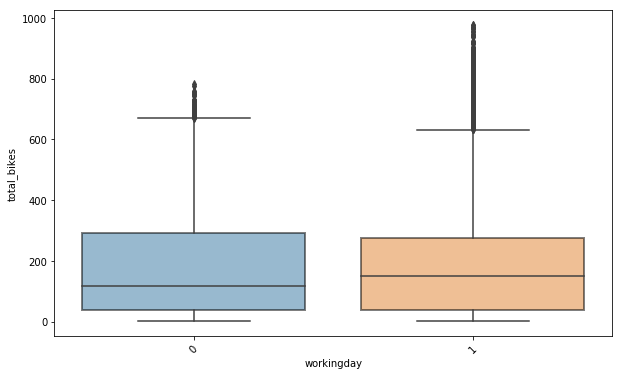

In [17]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='workingday', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

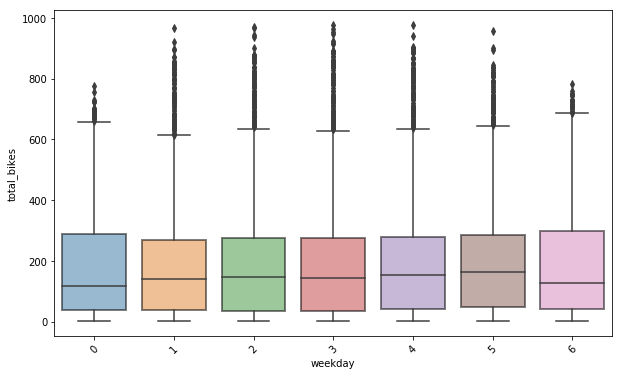

In [18]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='weekday', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

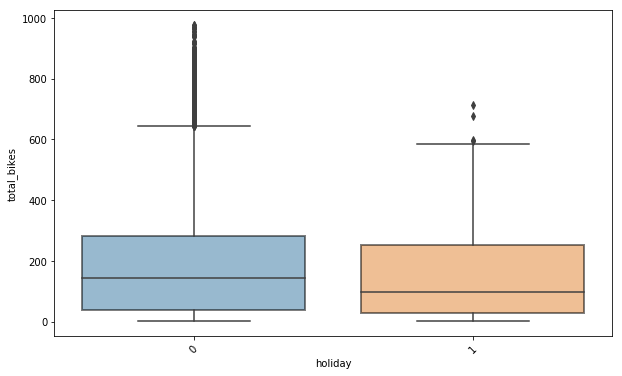

In [19]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='holiday', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)